In [3]:
!pip install ipynb
import ROOT
from ROOT import TCanvas, TGraph, gROOT
import numpy as np
import time
import matplotlib.pyplot as plt
import time 
from array import array
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator
from ipynb.fs.defs.Simulation_Ruben import noise_generator, signal_generator

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


Random number from PDF: 256.586517
TFile**		hits-per-interaction_PDF.root	
 TFile*		hits-per-interaction_PDF.root	
  OBJ: TH1F	Histo_hits_per_event	HGTD hits for 100 interactions : 0 at: 0x7c7a320
  KEY: TH1F	Histo_hits_per_event;1	HGTD hits for 100 interactions


Warning in <TCanvas::Constructor>: Deleting canvas with same name: Canvas


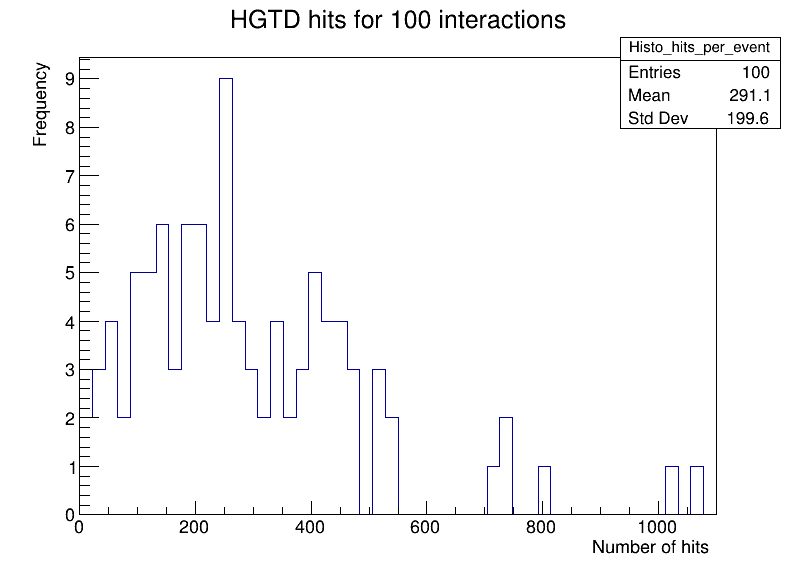

In [31]:
# Load the file and get the tree
f = ROOT.TFile.Open("hits-per-interaction_PDF.root", "READ")
PDF_per_interaction = f.Get("Histo_hits_per_event")
# Print out the objects and branches
f.ls()
c1 = ROOT.TCanvas("Canvas", "Title", 800, 600)
PDF_per_interaction.Draw() 
c1.Draw()
rando = PDF_per_interaction.GetRandom()
print("Random number from PDF: %f"%rando)

In [17]:
def simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, threshold, peak_mpv_voltage, guess_mpv_voltage, large_window_factor):
    """For a number of BC, we get two lists: total_actual_signal_count and total_estimated_signal_count for each BC"""

    channel_count = nr_of_channels*ratio_of_channels_to_sample
    #avg_particles_reaching_detector = channel_count * signal_to_channel_count_ratio

    #generate the noise
    noise_gen = noise_generator(threshold, channel_count, large_window_factor)
    #generate the signal
    signal_gen = signal_generator(threshold, peak_mpv_voltage, guess_mpv_voltage)

    result_true_signal_count = np.zeros(bunch_crossings)
    result_estimated_signal_count = np.zeros(bunch_crossings)
    error_estimation = 0
    signal_fraction_above = signal_gen.fraction_above
    deviation_from_true = np.zeros(bunch_crossings)
    for BC in range(bunch_crossings):
        print("\nBunch Crossing %d:" %(BC+1))
        print("----------------------------")
        # both results are in small window, both are noise above threshold
        noise_exact, noise_est = noise_gen.generate()

        # The paramater is the expected number of particles that reach the detector.
        # The first return value is the number of particles that reached the detector and 
        # the second return value is the number of activated channels.
        total_actual_signal, signal_above = signal_gen.generate(expected_count)
        print ("True signal: %f"%total_actual_signal)
        print ("True noise: %f"%noise_exact)
        print ("Signal above threshold: %f"%signal_above)
        # from the total activations, estimate how much was produced by actual signal
        total_activations = signal_above + noise_exact  # total activations in small window (i.e. above threshold)
        
        print("Total activations: %d" %(total_activations))
        #total real activations minus estimation of signal, then divide with the prob. mass for Landau to be above threshold
        total_signal_est = (total_activations - noise_est)/signal_fraction_above 
        print("Total signal estimation: %f"%total_signal_est)
        print ("Noise estimate: %f"%noise_est)
        # assign the results
        result_true_signal_count[BC] = total_actual_signal #exact count in the small window
        result_estimated_signal_count[BC] = total_signal_est #estimated count 
        
        deviation_from_true[BC] = total_signal_est - total_actual_signal
        print ("Deviation from true: %f"%deviation_from_true[BC])
                
    deviation_from_true = deviation_from_true/bunch_crossings
    print (deviation_from_true)

    return result_true_signal_count, result_estimated_signal_count, deviation_from_true

In [14]:
nr_of_channels = int(3.6 * 1e6) #number of channels on the HGTD

mu = 0.01 # Parameter for the number of interaction in a bunch crossing
bunch_crossings = 50 

large_window_factor = 8 #How many times the large window is bigger than the smaller one

"""exp number of particles on detector proportional to mu, try also non-linear relationship as in christian's plot """
expected_count = (15*1e3/200)*mu #expected number of particles reaching the HGTD for mu=200, no more than 20k
print("Expected count: %f" %expected_count)

ratio_of_channels_to_sample = 0.5 # Choose according to how many channels, or which part of the detector, are hit

# Thresholds for the simulation
min_threshold = 15#mV
max_threshold = 45#mV
threshold_steps = 10 #Number of steps

# To simulate only a single mpv of peak voltage, put same value for min and max, and step=1 
min_mpv_peak = 100 #mV, the sensor at its worst state
max_mpv_peak = 100 #mV, new sensors
mpv_peak_steps = 1 # Number of steps
guess_mpv_voltage_bias = 1 # Set the bias of guessed mpv voltage, e.g. 0.97 for a 3% bias

Expected count: 0.750000


In [18]:
true_signal, estimated_signal, dev_per_BC = simulation (nr_of_channels, ratio_of_channels_to_sample, expected_count, bunch_crossings, 25, 100, 100*guess_mpv_voltage_bias, large_window_factor)



Bunch Crossing 1:
----------------------------
True signal: 1.000000
True noise: 1.000000
Signal above threshold: 1.000000
Total activations: 2
Total signal estimation: 1.714438
Noise estimate: 0.285714
Deviation from true: 0.714438

Bunch Crossing 2:
----------------------------
True signal: 0.000000
True noise: 0.000000
Signal above threshold: 0.000000
Total activations: 0
Total signal estimation: 0.000000
Noise estimate: 0.000000
Deviation from true: 0.000000

Bunch Crossing 3:
----------------------------
True signal: 0.000000
True noise: 0.000000
Signal above threshold: 0.000000
Total activations: 0
Total signal estimation: 0.000000
Noise estimate: 0.000000
Deviation from true: 0.000000

Bunch Crossing 4:
----------------------------
True signal: 0.000000
True noise: 1.000000
Signal above threshold: 0.000000
Total activations: 1
Total signal estimation: 1.000089
Noise estimate: 0.000000
Deviation from true: 1.000089

Bunch Crossing 5:
----------------------------
True signal: 0.0